# Exploratory Data Analysis for Text Data

* Purpose: to help setting hyperparmeters for BERT models fine-tuning properly.

Date: 11/28/2025

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re



In [2]:
df = pd.read_csv('.\input\imdb.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## 1. Class Balance Check 
(eg. 50% positive - 50% negative)

##### **Purpose**: To know if we could safely trust accuracy metrics, and if we need to deal with class imbalance during modeling.


In [6]:
df.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

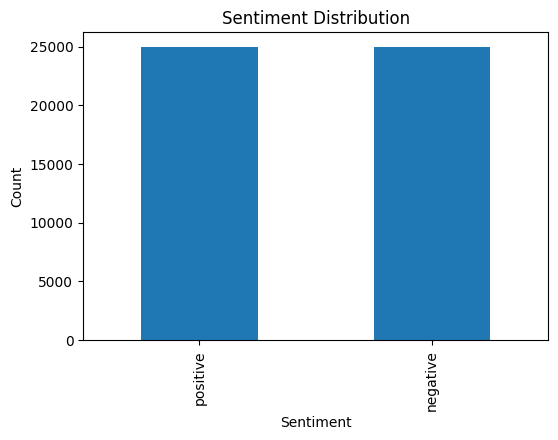

In [5]:
df.sentiment.value_counts().plot(kind='bar', figsize=(6, 4))
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

* Conclusion: The percentage is very equally distributed. Accuracy could be safely used as the main metric.

## 2. Sequence Length Analysis


##### **Purpose**: To find the minimum `MAX_LEN` that captures the vast majority of review data, and to save valuable VRAM. 
(BERT works on tokens, but we'll approximate with word counts for simplicity and speed in EDA.)

In [ ]:
# Calulate the number of words in each review
df['word_count'] = df['review'].apply(lambda x: len(x.split()))
df['word_count'].describe()

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: word_count, dtype: float64

In [ ]:
# Calculate the 95th percentile of word counts
p95 = df['word_count'].quantile(0.95)
print(f'95th Percentile of Word Counts: {p95}')
p95 = df['word_count'].quantile(0.75)
print(f'95th Percentile of Word Counts: {p95}')

95th Percentile of Word Counts: 590.0


In [16]:
# Count how many reviews have extreme word counts
extreme_threshold = df['word_count'].quantile(0.95)
extreme_count = (df['word_count'] > extreme_threshold).sum()
print(f'Reviews with word count > 95th percentile: {extreme_count}')

Reviews with word count > 95th percentile: 2498


In [17]:
mean_no_95 = df['word_count'][df['word_count'] <= extreme_threshold].mean() #create boolean mask to filter out extreme values
print(f'Mean word count (up to 95th percentile): {mean_no_95}')

Mean word count (up to 95th percentile): 202.788787840512


In [18]:
# Calculate mean excluding outliers (using IQR method)
Q1 = df['word_count'].quantile(0.25)
Q3 = df['word_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mean_no_outliers = df['word_count'][(df['word_count'] >= lower_bound) & (df['word_count'] <= upper_bound)].mean()
print(f'Mean word count (excluding IQR outliers): {mean_no_outliers}')


Mean word count (excluding IQR outliers): 193.74684610731876


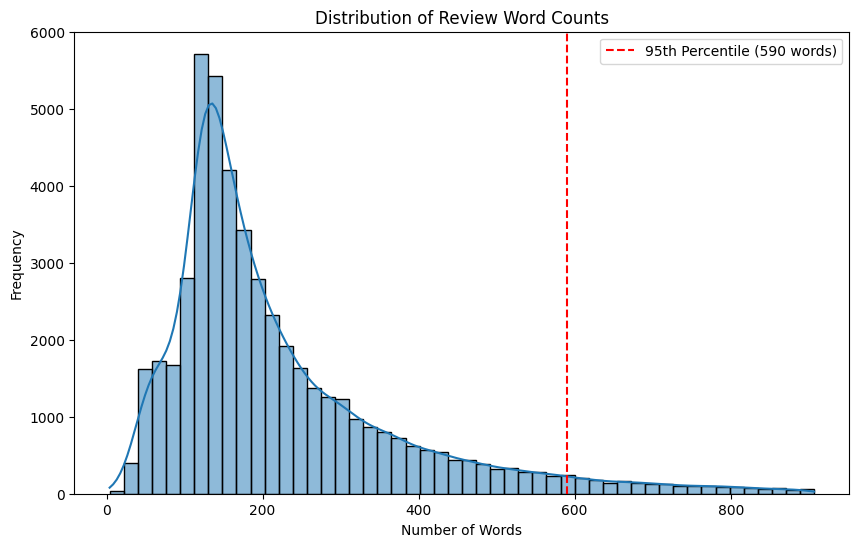

In [19]:
plt.figure(figsize=(10, 6))
# Only plot reviews up to a reasonable cap (e.g., the 99th percentile)
sns.histplot(df['word_count'][df['word_count'] < df['word_count'].quantile(0.99)], bins=50, kde=True)
plt.axvline(x=p95, color='r', linestyle='--', label=f'95th Percentile ({p95:.0f} words)')
plt.title('Distribution of Review Word Counts')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

* Conclusions:
1. 95% of the Reviews are <= 590 words.
2. If VRAM is limited (e.g., 8GB GPU): Set MAX_LEN to $128$ or $256$ tokens. Sentiment is often expressed early in the review, and a shorter length may yield good results while keeping training fast.
3. If VRAM allows (e.g., 16GB+ GPU): Set MAX_LEN to the maximum limit, $512$ tokens. This captures the most information.

## 3. Top Word Frequency (optional)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\IgnacioKleinmanRuiz\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!



--- Top 20 Non-Stop Words ---
      Word  Frequency
0    movie      85223
1     film      76028
2      one      51476
3     like      39064
4     good      28912
5     even      24583
6    would      24036
7     time      23960
8   really      23011
9      see      22640
10   story      22512
11    well      19228
12    much      19109
13     get      18244
14     bad      17990
15   great      17934
16    also      17857
17  people      17710
18   first      17207
19    dont      16972


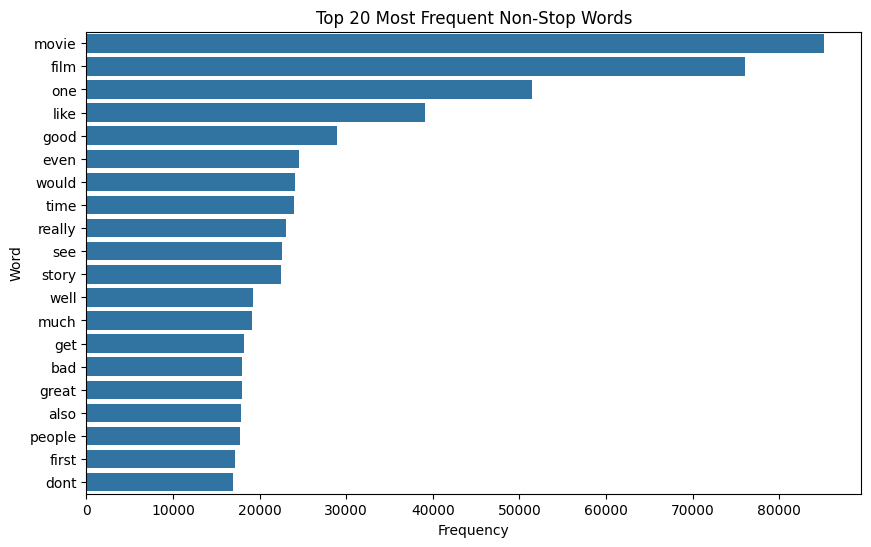

In [21]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
# Run this once if you haven't:
nltk.download('stopwords') 

# Top Word Frequency

stop_words = set(stopwords.words('english'))

def get_top_words(text_series, n=20):
    """Tokenizes, removes punctuation/stopwords, and counts words."""
    all_words = []
    
    # Simple tokenization and cleaning
    for text in text_series:
        # Remove punctuation and split into words
        text = re.sub('<br />', ' ', text) 
        text = re.sub(r'[^\w\s]', '', str(text).lower())
        words = text.split()
        
        # Filter out stop words
        filtered_words = [word for word in words if word not in stop_words]
        all_words.extend(filtered_words)
    
    # Count frequency
    word_counts = Counter(all_words)
    return pd.DataFrame(word_counts.most_common(n), columns=['Word', 'Frequency'])

top_20_words = get_top_words(df['review'])
print("\n--- Top 20 Non-Stop Words ---")
print(top_20_words)

# Optional: Visualize top words
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=top_20_words)
plt.title('Top 20 Most Frequent Non-Stop Words')
plt.show()